### Installing Required Libraries

In [19]:
#pip install requests beautifulsoup4 xlsxwriter --quiet

#### Importing Libraries

In [20]:
import requests
from bs4 import BeautifulSoup
import json
import xlsxwriter
import os
import warnings
warnings.simplefilter("error", category=FutureWarning)




⚠️ Note:
This project extracts publicly available embedded JSON data from YouTube pages.
Since YouTube frequently changes its internal structure, this scraper may require
updates in the future.

In [21]:
#Define directory
BASE_DIR = os.getcwd()
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPUT_FILE = os.path.join(OUTPUT_DIR, "youtube_videos.csv")



In [22]:
#Sending HTTP Request to YouTube Page
url = "https://www.youtube.com/channel/UC0RhatS1pyxInC00YKjjBqQ/videos"
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)
html = response.text

In [23]:
#Creating the BeautifulSoup Object
soup = BeautifulSoup(html, "html.parser")

In [24]:
#Extracting Embedded YouTube JSON Data

# Find the script tag that contains ytInitialData
script_tag = soup.find("script", string=lambda t: t and "ytInitialData" in t)
json_text = script_tag.string.strip()[len("var ytInitialData = "):-1]
data = json.loads(json_text)

if script_tag:
    raw_text = script_tag.string.strip()
    # Remove prefix and trailing semicolon safely
    prefix = "var ytInitialData = "
    if raw_text.startswith(prefix):
        json_text = raw_text[len(prefix):-1]
    else:
        json_text = raw_text
    data = json.loads(json_text)
    print("JSON parsed successfully")
else:
    print("ytInitialData not found")
if script_tag:
    raw_text = script_tag.string.strip()
    # Remove prefix and trailing semicolon safely
    prefix = "var ytInitialData = "
    if raw_text.startswith(prefix):
        json_text = raw_text[len(prefix):-1]
    else:
        json_text = raw_text
    data = json.loads(json_text)
    print("JSON parsed successfully")
else:
    print("ytInitialData not found")


JSON parsed successfully
JSON parsed successfully


In [25]:
#Navigating to Video Metadata

videos_data = data['contents']['twoColumnBrowseResultsRenderer']['tabs'][1]\
              ['tabRenderer']['content']['richGridRenderer']['contents']

In [26]:
#Extracting Titles, Views and Durations
titles, views, durations = [], [], []
count = 0

for item in videos_data:
    try:
        video = item['richItemRenderer']['content']['videoRenderer']
        titles.append(video['title']['runs'][0]['text'])
        views.append(video.get('viewCountText', {}).get('simpleText', 'N/A'))
        durations.append(video.get('lengthText', {}).get('simpleText', 'N/A'))
        count += 1
        if count >= 30:
            break
    except:
        continue

In [27]:
import pandas as pd

df = pd.DataFrame({
    "Title": titles,
    "Views": views,
    "Duration": durations
})

df.to_csv(OUTPUT_FILE, index=False)
print("Data Saved in CSV file:", OUTPUT_FILE)


Data Saved in CSV file: c:\Users\shukl\OneDrive\Desktop\Data-Analytics-Portfolio\Python\Web-Scraping\YouTube Video Analytics\outputs\youtube_videos.csv


### Data Preprocessing

In [28]:
# Importing the Data
import pandas as pd

data = pd.read_csv(OUTPUT_FILE)
data.head()

,Title,Views,Duration
0,DSA In Java | Graph 01 | Java in One Shot | Gr...,456 views,5:00:22
1,250+ Refunds Claimed | GeeksforGeeks Three 90 ...,566 views,0:50
2,Hack-4-Viksit Bharat Hackathon | Big Opportuni...,"5,562 views",37:29
3,DSA In Java | Backtracking | Java in One Shot ...,"3,503 views",4:04:45
4,DSA In Java | Binary Search On Answer | Java i...,"3,092 views",1:58:52


In [29]:
# Cleaning the Views Column

In [30]:
data['Views'] = data['Views'].str.replace(" views", "", regex=False).str.strip()
cleaned_views = []
for i in data['Views']:
    if pd.isna(i):  
        cleaned_views.append(None)
        continue

    i = str(i).replace(",", "")  

    if i.endswith('K') or i.endswith('k'):
        i = i.replace('K', '').replace('k', '')
        try:
            cleaned_views.append(float(i) * 1000)
        except:
            cleaned_views.append(None)
    else:
        try:
            cleaned_views.append(float(i))
        except:
            cleaned_views.append(None)

data['Views'] = cleaned_views

In [31]:
#Cleaning the Duration Column
#- Strips out newline symbols for cleaner text
#- Transforms durations into their equivalent seconds
#- Assigns None to entries that are invalid or missing

data['Duration'] = data['Duration'].str.replace("\n", "", regex=False)
def duration_to_seconds(duration_str):
    if pd.isna(duration_str) or duration_str in ['SHORTS', 'N/A']:
        return None
    parts = str(duration_str).split(':')
    if len(parts) == 3: 
        h, m, s = map(int, parts)
        return h * 3600 + m * 60 + s
    elif len(parts) == 2: 
        m, s = map(int, parts)
        return m * 60 + s
    return None

data['Duration'] = data['Duration'].apply(duration_to_seconds)


In [32]:
#Categorizing Videos by Duration

data['Duration'] = data['Duration'].astype('object')

for i in data.index:
    val = data.loc[i, 'Duration']
    
    if pd.isna(val):
        continue
    elif val < 900:
        data.loc[i, 'Duration'] = 'Mini-Videos'
    elif val < 3600:
        data.loc[i, 'Duration'] = 'Long-Videos'
    else:
        data.loc[i, 'Duration'] = 'Very-Long-Videos'

print(data.head())


                                               Title   Views          Duration
0  DSA In Java | Graph 01 | Java in One Shot | Gr...   456.0  Very-Long-Videos
1  250+ Refunds Claimed | GeeksforGeeks Three 90 ...   566.0       Mini-Videos
2  Hack-4-Viksit Bharat Hackathon | Big Opportuni...  5562.0       Long-Videos
3  DSA In Java | Backtracking | Java in One Shot ...  3503.0  Very-Long-Videos
4  DSA In Java | Binary Search On Answer | Java i...  3092.0  Very-Long-Videos


#### Text Preprocessing

In [33]:
import re
from tqdm import tqdm
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to C:\Users\shukl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shukl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\shukl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [34]:
# Initializing Stopwords and Stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [35]:
#Defining the Text Preprocessing Function
def preprocess_text(text_data):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        sentence = str(sentence).lower()

        sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence)
       
        sentence = re.sub(r'[^a-z\s]', '', sentence)
       
        tokens = word_tokenize(sentence)

        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

        preprocessed_text.append(" ".join(tokens))

    return preprocessed_text

In [36]:
## Applying Text Preprocessing on Video Titles

data['Title'] = preprocess_text(data['Title'].values)
data.head()

100%|██████████| 30/30 [00:00<00:00, 343.42it/s]


,Title,Views,Duration
0,dsa java graph java one shot graph java,456.0,Very-Long-Videos
1,refund claim geeksforgeek three challeng,566.0,Mini-Videos
2,hackviksit bharat hackathon big opportun stude...,5562.0,Long-Videos
3,dsa java backtrack java one shot backtrack java,3503.0,Very-Long-Videos
4,dsa java binari search answer java one shot bi...,3092.0,Very-Long-Videos


#### Visualization of video data

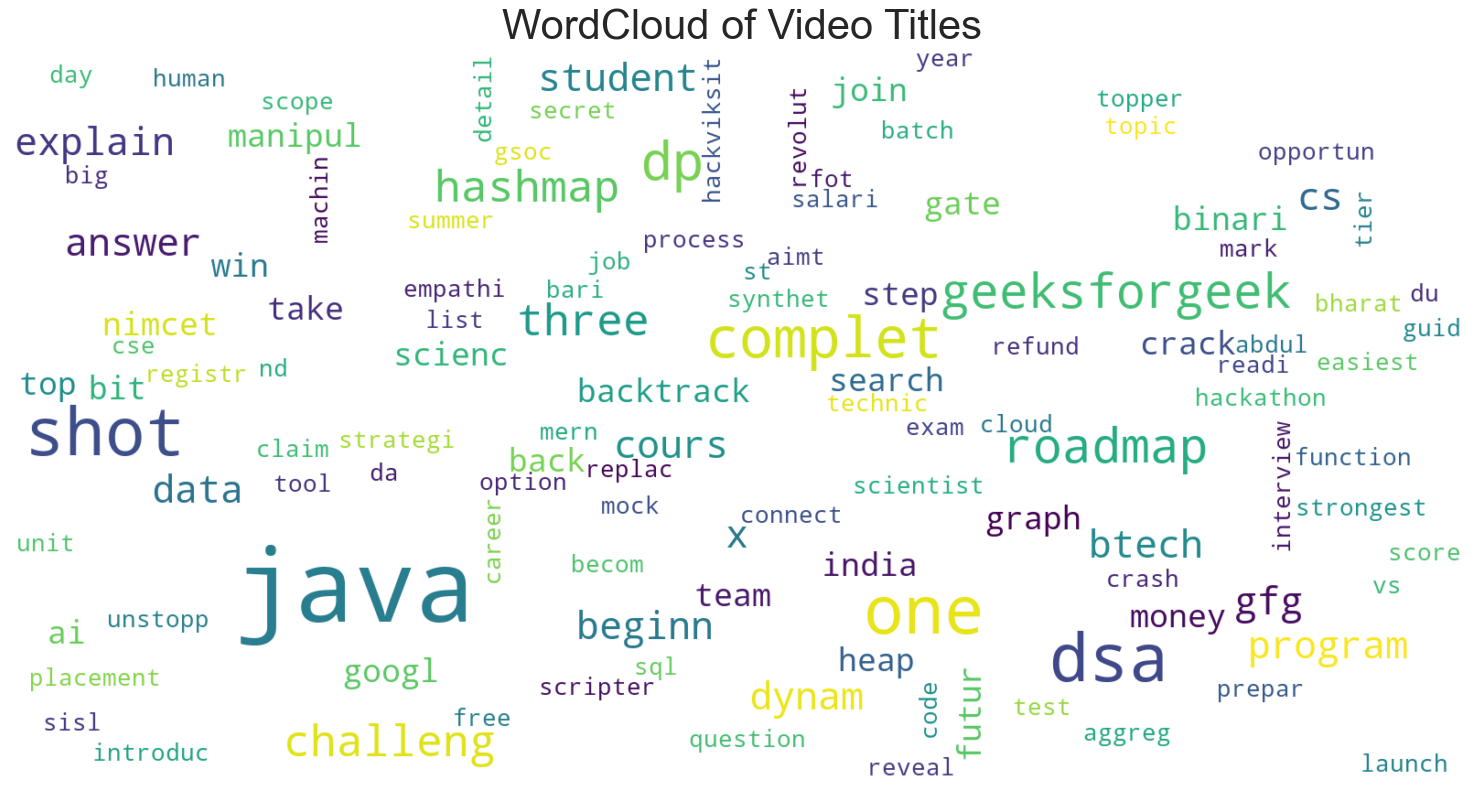

In [40]:
#Word Cloud of Video Titles
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

consolidated = ' '.join(word for word in data['Title'].astype(str))

wordCloud = WordCloud(width=1600,height=800,random_state=21,
                      max_font_size=110,collocations=False,background_color='white')

plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Video Titles", fontsize=30)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "wordcloud_titles.png"), dpi=300)
plt.show()


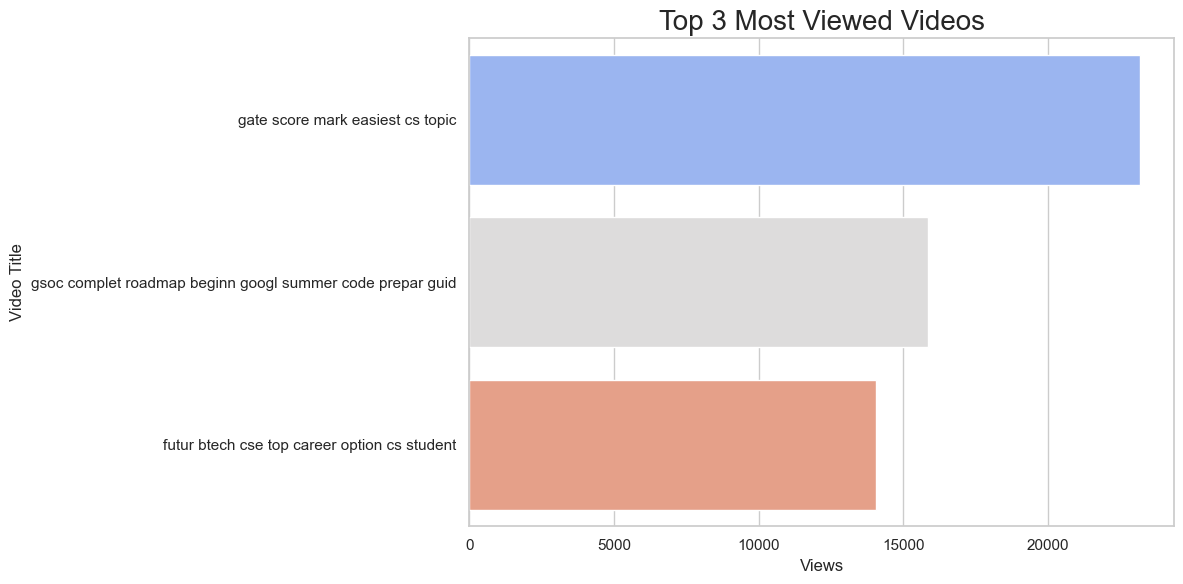

In [41]:
#Few Top Most Viewed Videos
top_videos = data.sort_values(by='Views', ascending=False).head(3)

plt.figure(figsize=(12, 6))
sns.barplot(x='Views', y='Title',hue='Title', data=top_videos, palette='coolwarm', estimator=sum)
plt.title("Top 3 Most Viewed Videos", fontsize=20)
plt.xlabel("Views")
plt.ylabel("Video Title")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "top_viewed_videos.png"), dpi=300)
plt.show()



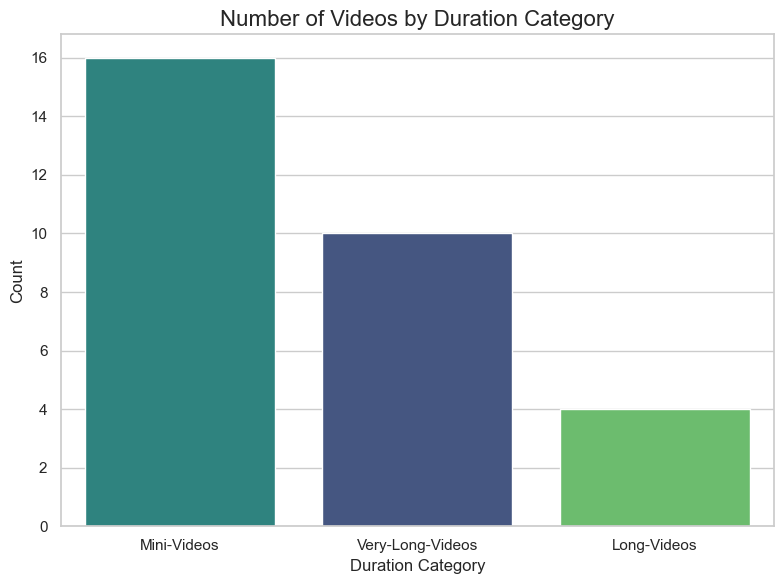

In [42]:
#Video Count by Duration Category
plt.figure(figsize=(8, 6))
sns.countplot(x='Duration', data=data,hue='Duration', palette='viridis',
    order=data['Duration'].value_counts().index)
plt.title("Number of Videos by Duration Category", fontsize=16)
plt.ylabel("Count")
plt.xlabel("Duration Category")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "duration_category.png"), dpi=300)
plt.show()


